# 1. Installing the libraries

In [34]:
!pip install datasets
!pip install tensorflow
!pip install transformers

# 2. Loading the libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf
from sklearn.utils import class_weight
from transformers import AutoTokenizer, TFBertForSequenceClassification, AdamW
from datasets import load_dataset, Dataset, DatasetDict
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# 3. Reading the Dataset

In [36]:
### The following Dataset is from :-
### ANDRII SAMOSHYN (2020). Hate Speech and Offensive Language Dataset [online]. [Accessed on 19 July 2023]
### Available from - https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset?ref=hackernoon.com
DATASET_FILE = "/content/drive/MyDrive/Colab Notebooks/Twitter_Hate_speech_Obscene_language.csv"
df = pd.read_csv(DATASET_FILE)
### end of citation

In [37]:
# Read the csv file using pandas
df = pd.read_csv(DATASET_FILE)
df.head(10)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


<Axes: xlabel='class', ylabel='count'>

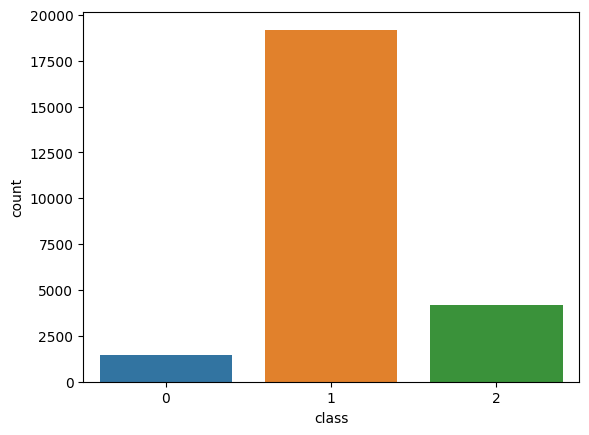

In [38]:
# Visualize class distribution
sns.countplot(x='class', data=df)

# 4. Pre-processing the Dataset

In [39]:
#preprocessing dataset
def word_check(word):
    word = word.lower()
    word = re.sub('\[.*?\]', '', word)
    word = re.sub("\\W"," ",word)
    word = re.sub('https?://\S+|www\.\S+', '', word)
    word = re.sub('<.*?>+', '', word)
    word = re.sub('[%s]' % re.escape(string.punctuation), '', word)
    word = re.sub('\n', '', word)
    word = re.sub('\w*\d\w*', '', word)
    return word

df['cleaned_tweet'] = df['tweet'].str.replace(r'@[A-Za-z0-9]+\s?', '', regex=True)
df['cleaned_tweet'] = df['cleaned_tweet'].apply(word_check)
df.head(10)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,cleaned_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldn t complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats cold tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt ganderson based she look like a ...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me ...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",madisonx the shit just blo...
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ...",brighterdays i can not just sit up an...
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,cause i m tired of you big bitches co...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",amp you might not get ya bitch back amp ...
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria...",hobbies include fighting mariam bitch


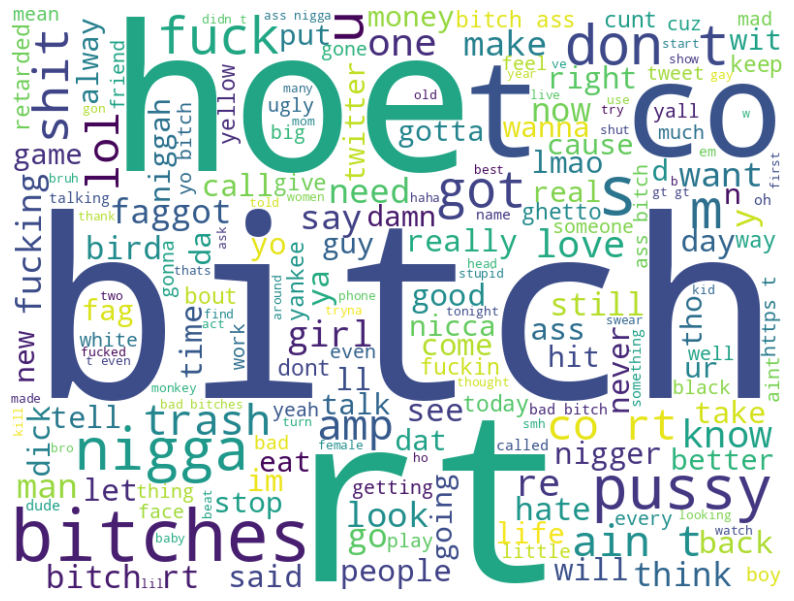

In [40]:
#Generating wordcloud
text = ' '.join(df['cleaned_tweet'].tolist())
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color='white', width=800, height=600).generate(text)

# Plotting the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 5. Converting to Hugging Face Dataset and Splitting the dataset

In [41]:
### The following code is from -
### Huggingface Documentation. Processing data in a Dataset. [online]. [Accessed on 22 july 2023].
### Available from - https://huggingface.co/docs/datasets/v1.8.0/processing.html
huggingface_dataset = Dataset.from_pandas(df)
splits = huggingface_dataset.train_test_split()
test_val_splits = splits['test'].train_test_split()
final_splits = DatasetDict({
    'train': splits['train'],
    'validation': test_val_splits['train'],
    'test': test_val_splits['test']
})
final_splits = final_splits.remove_columns(['hate_speech', 
                                            'offensive_language', 
                                            'neither',
                                            'Unnamed: 0', 
                                            'count'])
final_splits
### end of citation

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'cleaned_tweet'],
        num_rows: 18587
    })
    validation: Dataset({
        features: ['class', 'tweet', 'cleaned_tweet'],
        num_rows: 4647
    })
    test: Dataset({
        features: ['class', 'tweet', 'cleaned_tweet'],
        num_rows: 1549
    })
})

# 6. Initializing and applying the tokenization.

In [42]:
#Tokenization
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def apply_tokenization(dataset_instance):
    return bert_tokenizer(dataset_instance['cleaned_tweet'], padding='max_length', truncation=True, max_length=256)

final_splits = final_splits.map(apply_tokenization, batched=True)

Map:   0%|          | 0/18587 [00:00<?, ? examples/s]

Map:   0%|          | 0/4647 [00:00<?, ? examples/s]

Map:   0%|          | 0/1549 [00:00<?, ? examples/s]

# 7. Converting the dataset to Tensorflow format.

In [43]:
### The following code is from -
### Huggingface Documentation. Processing the data [online]. [Accessed on 24 july 2023].
### https://huggingface.co/learn/nlp-course/chapter3/2?fw=tf
dataset_names = ['train', 'validation', 'test']
tf_datasets = {}

for name in dataset_names:
    tf_datasets[name] = final_splits[name].remove_columns(['tweet', "cleaned_tweet"]).with_format('tensorflow')

def convert_to_tf_format(dataset, tokenizer, batch_size=12):
    return tf.data.Dataset.from_tensor_slices((
        {key: dataset[key] for key in tokenizer.model_input_names},
        dataset['class']
    )).shuffle(len(dataset)).batch(batch_size)

train_tf_data = convert_to_tf_format(tf_datasets['train'], bert_tokenizer)
valid_tf_data = convert_to_tf_format(tf_datasets['validation'], bert_tokenizer)
test_tf_data = convert_to_tf_format(tf_datasets['test'], bert_tokenizer)
### end of citation

# 8. Defining the model

In [44]:
#Model Definition
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 9. Compile the model with Adam optimizer

In [45]:
#Compile Model with Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
bert_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=tf.metrics.SparseCategoricalAccuracy())


# 10. Handeling class imbalance

In [46]:
#Using Class Weights to Handle Class Imbalance
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(df['class']),
                                                  y=df['class'])
class_weights_dict = dict(enumerate(class_weights))

# 11. Training the model with Early stopping and ReduceLR

In [47]:
### This code is from-
### Tensorflow Documentation. tf.keras.callbacks.EarlyStopping [online]. [Accessed 02 August 2023]
### Available from - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=4,
                                                  restore_best_weights=True)

### end of citation.

### This code is from-
### Tensorflow Documentation. tf.keras.callbacks.ReduceLROnPlateau [online]. [Accessed on 02 August 2023].
### Available from - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=4,
                                                 min_lr=1e-7)

### end of citation.

training_history = bert_model.fit(
    train_tf_data,
    validation_data=valid_tf_data,
    epochs=5,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)

Epoch 1/5
1549/1549 [==============================] - 1127s 686ms/step - loss: 0.5982 - sparse_categorical_accuracy: 0.7940 - val_loss: 0.5518 - val_sparse_categorical_accuracy: 0.8464 - lr: 5.0000e-05
Epoch 2/5
1549/1549 [==============================] - 1055s 681ms/step - loss: 0.4731 - sparse_categorical_accuracy: 0.8115 - val_loss: 0.4749 - val_sparse_categorical_accuracy: 0.7930 - lr: 5.0000e-05
Epoch 3/5
1549/1549 [==============================] - 1056s 682ms/step - loss: 0.4074 - sparse_categorical_accuracy: 0.8177 - val_loss: 0.4136 - val_sparse_categorical_accuracy: 0.8683 - lr: 5.0000e-05
Epoch 4/5
1549/1549 [==============================] - 1055s 681ms/step - loss: 0.3519 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.4170 - val_sparse_categorical_accuracy: 0.8666 - lr: 5.0000e-05
Epoch 5/5
1549/1549 [==============================] - 1054s 681ms/step - loss: 0.3110 - sparse_categorical_accuracy: 0.8681 - val_loss: 0.3829 - val_sparse_categorical_accuracy: 0.8623 - 

# 12. Plotting Train and Val Loss

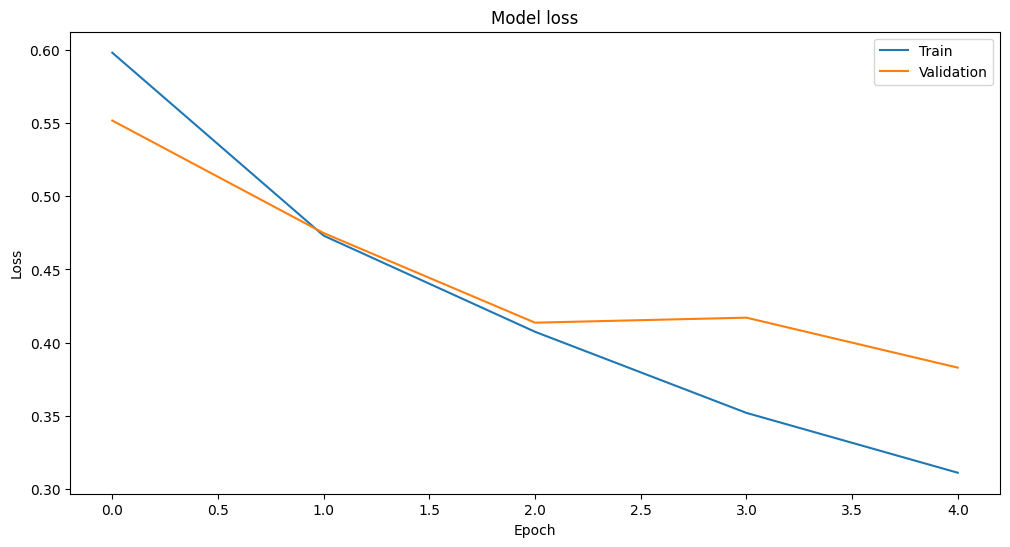

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# 13. Checkpoint

In [49]:
#Save and Load the Model
bert_model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/saved_model")
loaded_model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/saved_model")

Some layers from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/saved_model were not used when initializing TFBertForSequenceClassification: ['dropout_151']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


# 14. Model Evaluation

In [50]:
#Evaluation on Test Data
test_loss, test_accuracy = bert_model.evaluate(test_tf_data, verbose=1)
print('\nTest accuracy:', test_accuracy)

130/130 [==============================] - 30s 229ms/step - loss: 0.4235 - sparse_categorical_accuracy: 0.8360

Test accuracy: 0.836023211479187


In [51]:
# Calculate F1 score
from sklearn.metrics import f1_score

y_true = tf_datasets['test']['class'].numpy().tolist()
y_pred_logits = bert_model.predict(test_tf_data).logits
y_pred = np.argmax(y_pred_logits, axis=1)
f1 = f1_score(y_true, y_pred, average='weighted')
print('\nF1 score:', f1)

130/130 [==============================] - 34s 229ms/step

F1 score: 0.5670868242351832


# 15. Prediction on unseen data

In [57]:
classification_mapping_dict = {0: 'Hate speech',
                               1: 'Offensive Language',
                               2: 'Neither'}
model_output = loaded_model(bert_tokenizer(["Don’t challenge Death to a pillow fight. Unless you’re prepared for the reaper cushions"],
                                           return_tensors="tf", padding=True, truncation=True))['logits']
predicted_classes = np.argmax(model_output, axis=1)
for class_index in predicted_classes:
    print(classification_mapping_dict[class_index])

Neither
